# EEG analysis in MNE tutorial

MNE is a valuable Python package for neuroimaging data analysis. Working in MNE follows basic principles of Python programming and common logic of other popular DS libraries (NumPy, SciPy, Pandas). The documentation for MNE can be found [here](https://mne.tools/stable/index.html). 

This tutorial assumes knowledge of basic Python syntax and data structures and is mainly made for new students coming to the Lab.

(created by Felix Zakirov https://github.com/fzakirov/)

In [ ]:
# if you are going to use MNE for the first time, you should firstly install it!

# pip install mne

In [135]:
# importing basic set of packages (as well as MNE) required in almost any data analysis pipeline
import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## EEG preprocessing

In this tutorial we will be working with sample recording "ID001.fif". Note, that your recordings can have different filetypes (.eeg/.edf or some other), so pay attention to reading file functions! In the cell below we will also apply 0.1-40 Hz filter after reading, just for convenience. You can remove this string if you want to apply your filter later.

In [176]:
# reading raw EEG + filtering
raw=mne.io.read_raw_fif('ID001.fif', preload=True)
raw.filter(0.1, 40.,phase='zero-double');

Opening raw data file ID001.fif...
    Range : 0 ... 347069 =      0.000 ...   694.138 secs
Ready.
Reading 0 ... 347069  =      0.000 ...   694.138 secs...


C:\Users\nilsk\AppData\Local\Temp\ipykernel_4928\2032528310.py:2: RuntimeWarning: This filename (ID001.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('ID001.fif', preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    3.7s finished


The cell below will plot the whole recording which we have already put into "raw" variable. If you are new to M/EEG you may just scroll and see how many channels we have here and how the recording looks like. However, in terms of data analysis and prepocessing, this step is commonly used to briefly assess overall quality of your recording (eg indicate bad channels/bad segments of the recording). Also note that your plot will be interactive only if you have previously imported matplotlib as qt.

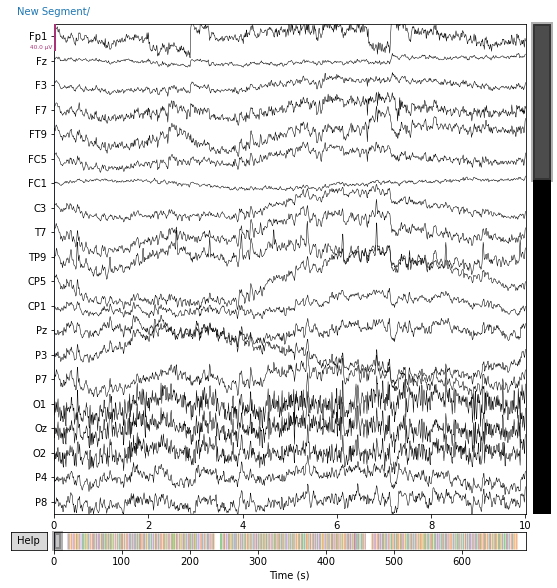

In [117]:
# look through recording, indicating bad channels
raw.plot();

Our recording has 64 channels and know we can apply a standard 10-20 montage to it. Applying montage on this step is not obligatory and won't affect some of your analysis and plotting. However, we'll need the montage to be set for plotting topomaps and many other features!

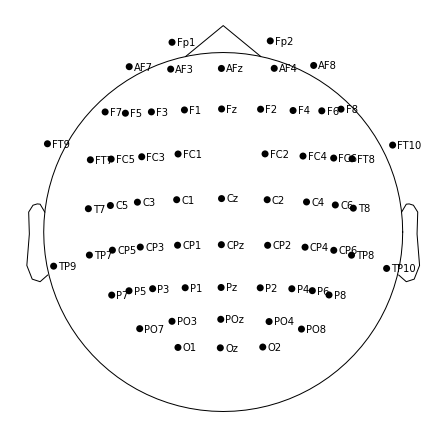

In [177]:
# setting 10-20 montage
raw.set_montage('standard_1020')
raw.plot_sensors(show_names=True);

While working with EEG you'll often need to look at event-related brain activity (response). These events usually stand for the presented stimuli (sound, image, text, etc.). Each stimulus has its timestamp and unique ID which makes onset of each stimulus (or type of stimulus) available to be found and distinguished in the recording. As a rule, these timesamps are sent to EEG processor via stimulus presenting software so that you final EEG file will also contain these stamps.

To extract the events (timestamps and IDs of each presented stimulus) we will use the code below:

In [153]:
# extracting events info
events=mne.events_from_annotations(raw)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4']


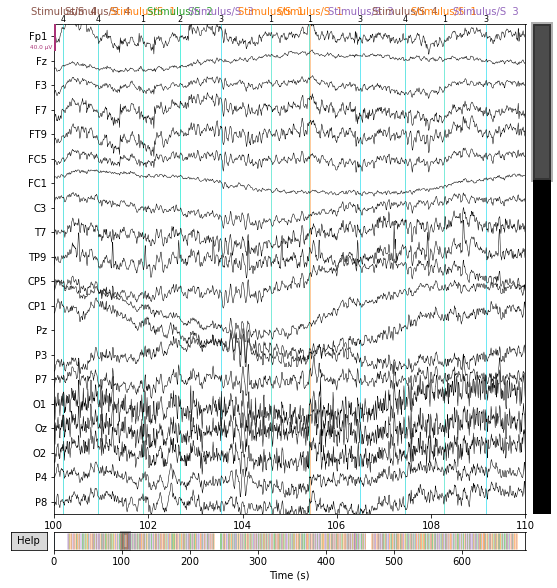

In [154]:
raw.plot(events=events[0], start=100);

We see that now events are plotted on the recording and there are generally 4 types of events (Stimulus/S 1-4). In this case, each type represents different sound intensity (50, 60, 70, 80 dB), but this can be any other thing, depending on your research. Sometimes it is also important to look at the structure of your events, i e how they are distributed in time and in relation to each other. Sometimes you can see some of your expected events are missing, or even found events you are not expecting to see at all! We'll use the code below to inspect our events in a simple plot.

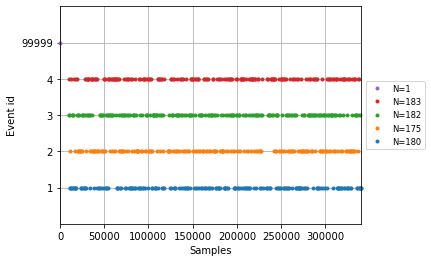

In [155]:
mne.viz.plot_events(events[0]);

Note that the timeline in the bottom of the plot doesn't really correspond to seconds but to timestamps. This will happen until you not specify the sampling frequency explicitly in the plotting function (or unless it is not equal 1000)!

Having the events extracted we are now able to further inspect the bad/noisy channels, but for epochs instance in this case. To plot the epochs you first need to extract them by passing 'raw' and 'events' to the mne.Epochs function. Later we will also consider some addiotional arguments for this function which help us to extract more pecise epochs.

Not setting metadata
721 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


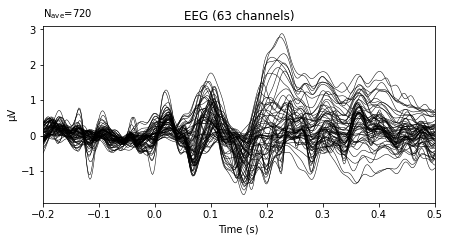

In [156]:
# inspecting evoked for bad channels
epochs=mne.Epochs(raw, events[0])
epochs.average().plot();

Note that in the cell above we have a plot of averaged epochs (also called evoked) object. Each line of the plot represent one of the EEG channels. Plotting epochs in this manner not only helps us to visualize event-related data, but also provides another way of investigating the recording for bad channels. 

In [ ]:
# defining list of channels to reject/interpolate
list_of_bads=[]

Basically, there are 2 ways of how to deal with bad channels: one can drop them or interpolate. In the first case you will remove the data of the dropped channel and exclude it from the further analysis. You also won't be able to make grand averaging for this channels (ie you will have to exclude the removed channel from all the partipicant if performing grand average). Another approach is interpolation which conceptually stands for approximation the values of the bad channel by calculating the average of neighboring good channels. There are some other approaches though, but we cover only basics here!

Here we'll perform interpolation of the bad channels we found earlier.

In [ ]:
# interpolating bads
raw.info['bads']=list_of_bads
raw.interpolate_bads()

In some cases you need to apply referencing on you recording. We will apply the average referencing for this one.

In [142]:
# average referencing
raw.set_eeg_reference(ref_channels='average');

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


The following step is very important for EEG prepocessing and is called ICA (independent component analysis). We won't discuss the precise mathematics behind this algorithm, but shall assume that it catches certain patterns in our recording (raw or epoch object) which in some cases can be artifacts (eg eye blinks, ECG and other). These artifacts should be eliminated from the data and thus make our data cleaner.

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 2.8s.


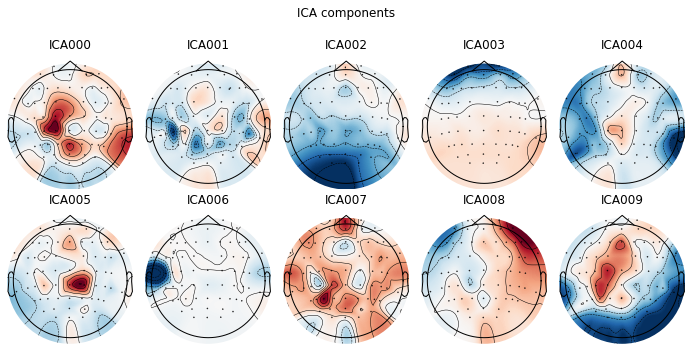

Creating RawArray with float64 data, n_channels=10, n_times=173535
    Range : 0 ... 173534 =      0.000 ...   694.136 secs
Ready.


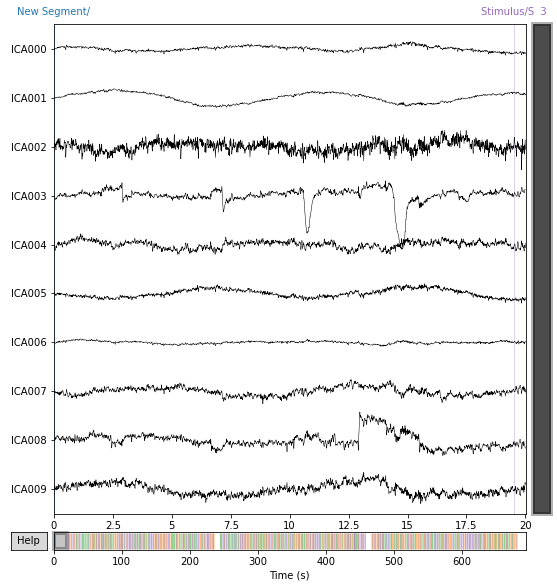

In [163]:
# ICA
raw=raw.resample(250)
ica=mne.preprocessing.ICA(n_components=10, random_state=97)
ica.fit(raw)
ica.plot_components(picks=range(10), inst=raw);
ica.plot_sources(raw);

Components 0 and 9 are highly likely to reflect eye-related activity (blinks), so that we'll exclude them and apply the ICA model on the raw data below.

In [164]:
ica_exclude=[3] #example

ica.exclude=ica_exclude
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 63 PCA components


<Raw | ID001.fif, 63 x 173535 (694.1 s), ~83.5 MB, data loaded>

Now essential preprocessing steps are finished, and we definitely should not forget to save our clen recording!

In [74]:
raw.save('ID001-clean.fif')

Writing C:\Users\nilsk\ID001-clean.fif


C:\Users\nilsk\AppData\Local\Temp\ipykernel_4928\3349701440.py:1: RuntimeWarning: This filename (C:\Users\nilsk\ID001-clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('ID001-clean.fif')


Closing C:\Users\nilsk\ID001-clean.fif
[done]


## Some kind of EEG analysis (hypothesis testing)

Remember that we had 4 stimulus types depending on sound intensity: 50dB, 60dB, 70dB, 80dB. Let's investigate whether the evoked response to sound changes with different intensity or remains the same? What effect do you expect for sound intensity to have on ERP amplitude? Firstly, we'll need to load our clean EEG data (it can be already in your 'raw' variable if you haven't reset the environment from the previous steps).

In [75]:
# reading clean EEG
raw=mne.io.read_raw_fif('ID001-clean.fif', preload=True)

Opening raw data file ID001-clean.fif...
    Range : 0 ... 173534 =      0.000 ...   694.136 secs
Ready.
Reading 0 ... 173534  =      0.000 ...   694.136 secs...


C:\Users\nilsk\AppData\Local\Temp\ipykernel_4928\169204138.py:2: RuntimeWarning: This filename (ID001-clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('ID001-clean.fif', preload=True)


To extract epochs from the clean file we'll need to define important parameters for epoching: threshold, tmin, tmax, and baseline. For typical ERP analysis it is enough to take the parameters as stated below.

In [178]:
# defining rejecting (peak-to-peak amplitude) for epoching if needed
threshold=dict(eeg=200e-6)
tmin=-0.2
tmax=0.5
baseline=(-0.2, 0.0)

In [179]:
# epoch extraction
epochs=mne.Epochs(raw, events[0],
                  reject=threshold, 
                  baseline=baseline, 
                  tmin=tmin, tmax=tmax, preload=True)

Not setting metadata
721 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 721 events and 351 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
13 bad epochs dropped


We can now save the extracted epochs. It is espcially important when trying different extracting options so that you won't lose any of the variants.

In [ ]:
# saving processed epochs
epochs.save('ID001-epo.fif')

To plot ERPs we need to create averaged epoch object (called evoked). We'll also try to plot each of the 4 types of stimulus to finally answer our research question: whether sound intensity has any effect on ERPs amplitude?

In [180]:
# create evoked object
evoked=epochs.average()

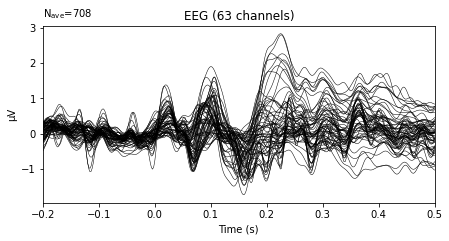

In [183]:
# plot evoked
evoked.plot();

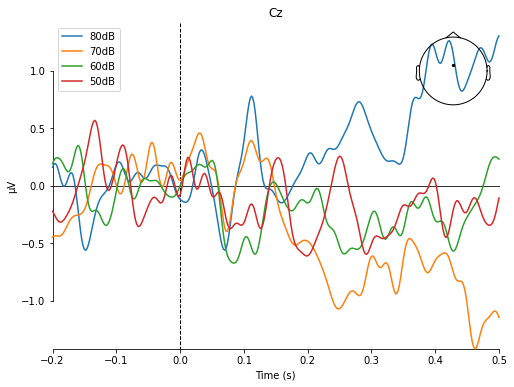

In [182]:
# plotting ERP
mne.viz.plot_compare_evokeds({'80dB':epochs['1'].average(),
                              '70dB':epochs['2'].average(),
                              '60dB':epochs['3'].average(),
                              '50dB':epochs['4'].average()
                              # epochs['2'].average():'70dB',
                              # epochs['3'].average():'60dB',
                              # epochs['4'].average():'50dB',
                             }, picks='Cz');

Although these ERPs don't look exactly as you get used to see in books - it is completely fine, because you were more likely to see grand averages rather than single subject! Looking briefly at these ERP we can see that P2 component amplitude seems to be intensity-dependent. How do you think? We'll definitely need to check this hypothesis on more subjects!